In [1]:
 import math
 import numpy as np
 import matplotlib.pyplot as plt
 %matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5

In [3]:
f(3.0)

20.0

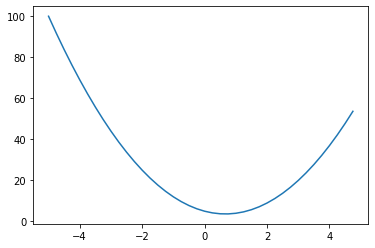

In [4]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 3.0
(f(x+h) - f(x))/h

14.000003002223593

In [6]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)
# 1. notice how the slope is equal to b when you change a. If you take the derivative of d1 you end up with b + c
# 2. notice that if you change b with h and take the slope you get 2 which is equal to a.

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [15]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, Label={self.label}, op?={self._op})"
    
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other): # other + self
        return self+other
        
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data*out.grad #a*b derivative of a with respect to something is b.
            other.grad += self.data*out.grad #then for the purposes of the chain rule you multiple by out.grad which is the previous derivate in back propogation
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += (other)*(self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        return self*other

    def __truediv__(self, other): #self / other
        return self * (other**-1)
    
    def __neg__(self): #-self
        return self*-1
    
    def __sub__(self, other): #self - other
        return self + (-other)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
d

Value(data=4.0, Label=d, op?=+)

In [16]:
d._prev

{Value(data=-6.0, Label=e, op?=*), Value(data=10.0, Label=c, op?=)}

In [17]:
d._op

'+'

In [22]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
#     print('nodes',nodes)
#     print('--------------------------')
#     print('edges',edges)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid=str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
#         print("{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad))
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

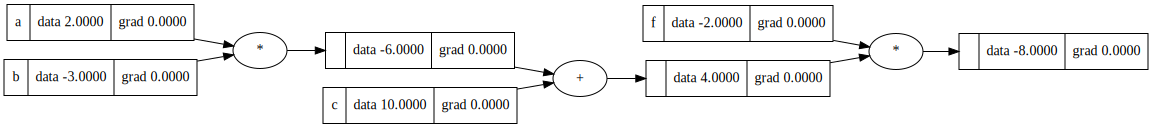

In [27]:
draw_dot(L)

In [26]:
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


In [14]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0+h, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
    
lol()

3.9999999999995595


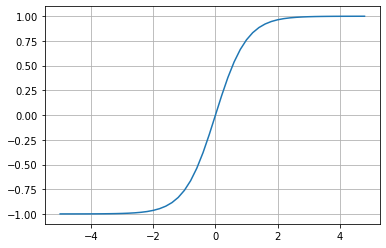

In [15]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [16]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); 
o.label = 'o'
o.backward()

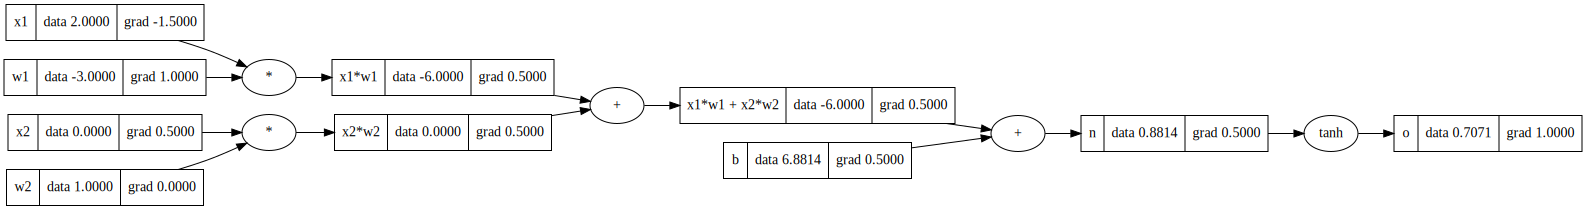

In [17]:
draw_dot(o)

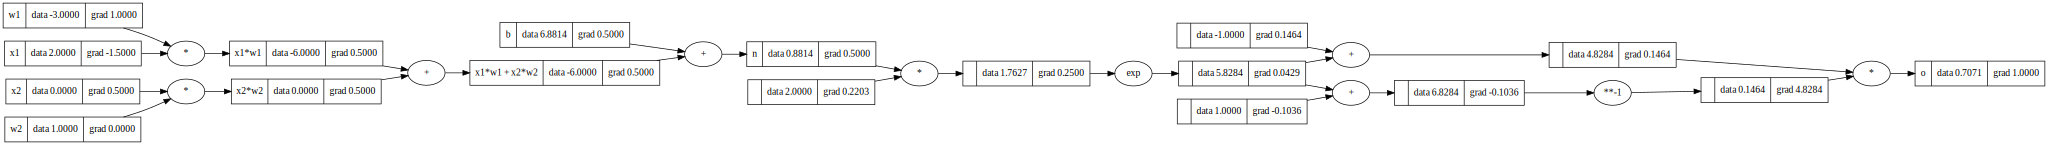

In [18]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
#----
e = (2*n).exp()
o = (e-1)/(e+1)
#----
o.label = 'o'
o.backward()
draw_dot(o)

In [19]:
import torch
import random

In [20]:
#neural nets are just a specific class of mathematical expressions


In [21]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self,x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        #print(outs)
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [22]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.44621639203600627)

In [23]:
n.parameters()

[Value(data=0.6064748555937547),
 Value(data=-0.4412652632979268),
 Value(data=-0.8270245802761933),
 Value(data=0.019335575327308785),
 Value(data=-0.7472585564747796),
 Value(data=-0.03871684095779293),
 Value(data=0.15705687530285406),
 Value(data=-0.36296736186066036),
 Value(data=0.14658786251911904),
 Value(data=0.44793298799567016),
 Value(data=-0.9565077603549783),
 Value(data=0.3258881482474423),
 Value(data=-0.5360533792476847),
 Value(data=0.014477976445951501),
 Value(data=-0.26777442895256676),
 Value(data=0.07872713981735191),
 Value(data=-0.6364915598235812),
 Value(data=0.9331206643295931),
 Value(data=0.15727367861646013),
 Value(data=0.9498967127348223),
 Value(data=0.8909441887458931),
 Value(data=-0.6885226468311962),
 Value(data=0.26196797866452304),
 Value(data=0.8083356021149699),
 Value(data=-0.4717838669115497),
 Value(data=-0.6512654995362921),
 Value(data=-0.14677261823908982),
 Value(data=-0.5804879727392278),
 Value(data=0.7821652843912386),
 Value(data=-0.

In [93]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [94]:
for k in range(20):
    
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    print(k, loss.data)

0 2.0378258649955055e-05
1 2.0360691443174433e-05
2 2.034315924903037e-05
3 2.0325661958135648e-05
4 2.0308199461571906e-05
5 2.0290771650879273e-05
6 2.0273378418060234e-05
7 2.0256019655574254e-05
8 2.0238695256338814e-05
9 2.022140511372052e-05
10 2.020414912153964e-05
11 2.018692717406132e-05
12 2.0169739165999387e-05
13 2.0152584992509654e-05
14 2.0135464549188152e-05
15 2.01183777320708e-05
16 2.0101324437629478e-05
17 2.008430456277036e-05
18 2.0067318004829988e-05
19 2.005036466157499e-05
